<a href="https://colab.research.google.com/github/elianaprosnitz/bio108tutorial/blob/main/Collab_github_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The impact of wildfires on threatened species richness in California**

This analysis explores the question of how wildfires in California are impacting the species richness, specifically the species richness of threatened species (as identified by the IUCN Red List). With the concering increase in CA wildfires, this exploration will shed light on how these disasters are impacting our most vulnerable species.

**QUESTION:**
Is there a relationship between 2024 threatened species richness and wildfire perimeters in Califonia?

First, import rasterio and necesary packages.

In [ ]:
!pip install rasterio
!pip install rasterstats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 27.1 MB/s eta 0:00:00


In [ ]:
# Import packages
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterio.mask
import rasterio.features
import rasterstats
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
from rasterio.crs import CRS
import fiona

Connect to Google Drive to access downloaded files.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import .tif file for Combined Species Richness in 2025 from IUCN database.

In [ ]:
SR_tif_path = '/content/drive/My Drive/Combined_THR_SR_2024/Combined_THR_SR_2024.tif'
SR_tif = rasterio.open(SR_tif_path)

Import .shp file for California State Boundary from data.gov database.


In [ ]:
california_shp_path = "/content/drive/MyDrive/ca_state/CA_State.shp"
california_boundary = gpd.read_file(california_shp_path)

Import .shp file for California wildfires from California State geoportal.

In [ ]:
CA_wildfire_shp_path = '/content/drive/My Drive/California_Fire_Perimeters_(all)/California_Fire_Perimeters_(all).shp'
CA_wildfire = gpd.read_file(CA_wildfire_shp_path)

Check the Coordinate Reference System (CRS) of raster data and shapefiles.

In [ ]:
SR_tif.crs

CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [ ]:
california_boundary.crs

<Projected CRS: PROJCS["Popular Visualisation CRS / Mercator",GEOG ...>
Name: Popular Visualisation CRS / Mercator
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
CA_wildfire.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Since the raster is in Mollweide projection, convert the California shapefiles from WGS 84 (lat/long) to match it.

In [ ]:
california_boundary = california_boundary.to_crs(SR_tif.crs)
CA_wildfire = CA_wildfire.to_crs(SR_tif.crs)

Plot the global species richness raster data and the CA boundary to see if it matches up and makes sense.

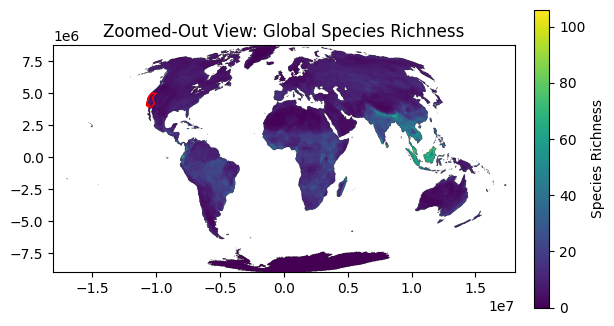

In [ ]:
fig, ax = plt.subplots()
rasterio.plot.show(SR_tif, ax=ax)
california_boundary.plot(ax=ax, edgecolor="red", facecolor="none")

#title plot
ax.set_title("Zoomed-Out View: Global Species Richness")

#Add a colorbar/legend to understand Species Richness
img = rasterio.plot.show(SR_tif, ax=ax, cmap="viridis")
cbar = plt.colorbar(img.get_images()[0], ax=ax, orientation="vertical", fraction=0.03, pad=0.04)
cbar.set_label("Species Richness")

plt.show()

Zoom in on the area of interest: California. To do this, define the bounding box to the bounds of the California state shapefile.

In [ ]:
#Define bounds for zoomed in plot
minx, miny, maxx, maxy = california_boundary.total_bounds

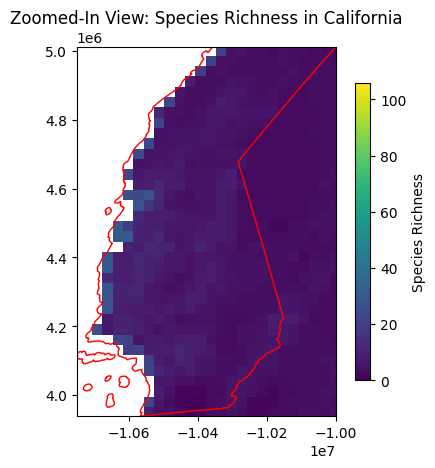

In [ ]:
fig, ax = plt.subplots()
rasterio.plot.show(SR_tif, ax=ax)
california_boundary.plot(ax=ax, edgecolor="red", facecolor="none")

# Set extent (zoom into California)
ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])

# title plot
ax.set_title("Zoomed-In View: Species Richness in California")

# SR colorbar
img = rasterio.plot.show(SR_tif, ax=ax, cmap="viridis")
cbar = plt.colorbar(img.get_images()[0], ax=ax, orientation="vertical", fraction=0.03, pad=0.04)
cbar.set_label("Species Richness")

plt.show()

Add the fire perimeter data onto the plot. I made the fire area transparent so as to still see the SR information beneath.

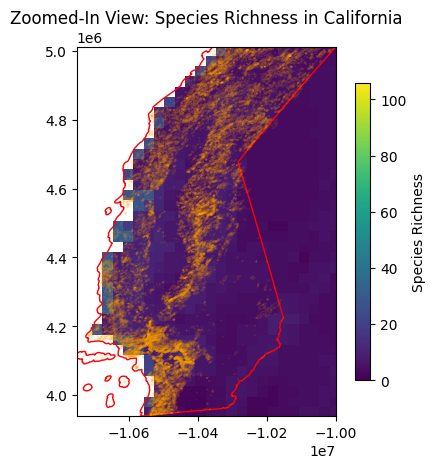

In [ ]:
fig, ax = plt.subplots()
rasterio.plot.show(SR_tif, ax=ax)
california_boundary.plot(ax=ax, edgecolor="red", facecolor="none")
CA_wildfire.plot(ax=ax, edgecolor="orange", alpha = 0.1, facecolor="none")

# Set extent (zoom into California)
ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])

# Labels
ax.set_title("Zoomed-In View: Species Richness in California")

# SR colorbar
img = rasterio.plot.show(SR_tif, ax=ax, cmap="viridis")
cbar = plt.colorbar(img.get_images()[0], ax=ax, orientation="vertical", fraction=0.03, pad=0.04)
cbar.set_label("Species Richness")

plt.show()

**Results:** There doesn't appear to be any obvious correlation between threatened species richness and fire zones in CA. There may be some decrease closer to the coasts.


If I were to perform this analysis again, I would alter the following:
*   Higher resolution species richness data for state level analysis
*   Convert raster data to lat/long instead of changing the shapefile (the use of a projection CRS likely accounts for the obvious distortion of state)
*   Actually clip the raster data to the shape of California, instead of just zooming into it. Likely would make furthur correlation analyses more seamless.
*   More carefully/intentionally associate the year the species richness data comes from and the year of wildfire data.












Below are some brainstormed attempts to clip the raster species richness data using the vector CA shapefile. I couldn't quite get it to work out.

In [ ]:
with fiona.open(california_shp_path, "r") as f:
    shapes = [feature["geometry"] for feature in f]

In [ ]:
out_image, out_transform = rasterio.mask.mask(SR_tif, shapes, crop=True)

Clip Species Richness data to just the state of California. New raster defined as CASR (California Species Richness).

In [ ]:
CASR_meta = SR_tif.meta.copy()
CASR_meta.update(
    {
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
    }
)

In [ ]:
with rasterio.open("Combined_THR_SR_2024_clip.tif", "w", **CASR) as dst:
    dst.write(out_image)

<Axes: >

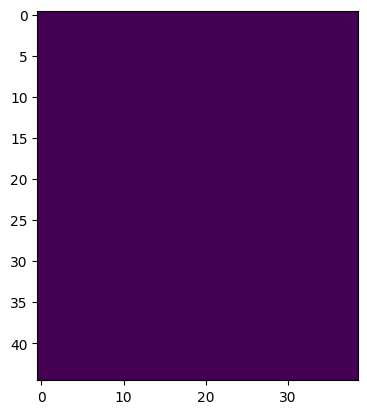

In [ ]:
fig, ax = plt.subplots()
rasterio.plot.show(out_image, ax=ax)